Create a data frame consisting of 1000 points.

The probability of making one or more accidental false discovery increases the more tests we perform. Multiple hypothesis testing occurs frequently in fields where we can generate a lot of features, and we need to test whether each of the features represents a possible novel discovery. For example, in genomics applied to disease studies we want to test whether any of the thousands of genes, has activity significantly different than in non-diseased individuals.

In this blog post, I will cover few of the popuar methods used to adjust p-values in these cases and explain when different approaches are sensible:

1. False Positive Rate (FPR)
2. Family-Wise Error Rate (FWER)
3. False Discovery Rate (FDR)

To run this code, we need Python with `pandas`, `numpy`, `scipy` and `statsmodels` libraries installed.

## Create test data

We will create a simulated example to better understand how various manipulation of p-values can lead to different conclusions.

For the purpose of this example, we start by creating a dataframe of 1000 features. 990 of which (99%) will have their values generated from a Normal distribution with mean = 0, called a Null model. 1% of the features will be generated from a Normal distribution mean = 3, called a Non-Null model.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

In [84]:
np.random.seed(42)

n_null = 9900
n_nonnull = 100

df = pd.DataFrame({
    'hypothesis': np.concatenate((
        ['null'] * n_null,
        ['non-null'] * n_nonnull,
    )),
    'feature': range(n_null + n_nonnull),
    'x': np.concatenate((
        norm.rvs(0, 1, size=n_null),
        norm.rvs(3, 1, size=n_nonnull),
    ))
})

For each of the 1000 feature, p-value is a probability of observing its value, if we assume it follows a Null hypothesis (sampled from a Normal distribution with 0 mean).

Cummulative Normal distribution `norm.cdf()` represents the probability of obtaining a value equal to or less than the one observed, so `1 - norm.cdf()` is a p-value:

In [85]:
df['p_value'] = 1 - norm.cdf(df['x'], loc = 0, scale = 1)

df

,hypothesis,feature,x,p_value
0,null,0,0.496714,0.309695
1,null,1,-0.138264,0.554984
2,null,2,0.647689,0.258593
3,null,3,1.523030,0.063876
4,null,4,-0.234153,0.592567
...,...,...,...,...
9995,non-null,9995,4.301102,0.000008
9996,non-null,9996,1.001655,0.158255
9997,non-null,9997,2.294683,0.010876
9998,non-null,9998,3.495766,0.000236


## False Positive Rate

The first concept is called a False Positive Rate, and is defined as a fraction of null hypothesis that we flag as "significant" (also called Type I errors). The "raw" p-values calculated above represent false positive rate by their very definition: p-values are the probabilities of obtaining a value at least as large when we sampled null distribution.

For the purpose of this example, we will apply a common (albeit somewhat arbitrary) threshold of 0.05:

In [86]:
df['is_raw_p_value_significant'] = df['p_value'] <= 0.05
df.groupby(['hypothesis', 'is_raw_p_value_significant']).size()

hypothesis  is_raw_p_value_significant
non-null    False                            8
            True                            92
null        False                         9407
            True                           493
dtype: int64

notice that 53 out of 990 null hypotheses are flagged as "significant". The False Positive Rate: FPR =  53 / (53 + 937) = 0.053. In other words, in our null model the probability of seeing a p-value lower or equal than 0.05 is... 0.05:

$$
P(\text{p-value} \leq 0.05) = 0.05
$$

We will use this result in the next section.

However, the main problem with FPR is that in a real scenario we do not a priori know which hypotheses are null and which are not. Then, the raw p-value on its own (False Positive Rate) can be of little use. In our case when the fraction of non-null features is very small, most of the features flagged as significant will be null, since there are many more of them.

Out of 59 features flagged true ("positive"), 53 are from null distribution, so false positives. That means that about 90% of reported significant features (53 / 59) are false, and is not particularly useful.

There are two common methods of addressing this issue: Family-Wise Error Rate and False Discovery Rate.

In [87]:
def correct_pvalues(p_values, method):
   return multipletests(p_values, method = method)[1]

## Family-Wise Error Rate

Famile-Wise Error Rate is a probability of rejecting one or more non-null hypothesis.

### Bonferroni correction

One of the most popular method for correcting for multiple hypothesis testing is a Bonferroni procedure. This procedure uses a threshold that is not 0.05, but instead 0.05 / 1000 (divided by the total number of tests).

$$

\text{FWER} = 
    P
    \left\{
        \bigcup_{i=1}^{990} \left(\text{p-value} \leq \frac{0.05}{1000} \right) 
    \right\} 
    
$$

$$
\text{FWER} \leq 
    \sum_{i=1}^{990} 
    \left\{
        P \left(\text{p-value} \leq \frac{0.05}{1000} \right)
    \right\}
$$

$$
\text{FWER} \leq 990 \frac{0.05}{1000} \leq 0.05.
$$

In [88]:
df['p_value_bonf'] = correct_pvalues(df['p_value'], 'bonferroni')
df.sort_values('p_value_bonf').head(20)

,hypothesis,feature,x,p_value,is_raw_p_value_significant,p_value_bonf
9907,non-null,9907,5.322609,5.114466e-08,True,0.000511
9942,non-null,9942,5.022174,2.554492e-07,True,0.002554
9943,non-null,9943,4.831177,6.786409e-07,True,0.006786
9941,non-null,9941,4.801528,7.872958e-07,True,0.007873
9976,non-null,9976,4.674271,1.475000e-06,True,0.014750
9964,non-null,9964,4.589147,2.225301e-06,True,0.022253
9974,non-null,9974,4.515318,3.161090e-06,True,0.031611
9990,non-null,9990,4.433625,4.633087e-06,True,0.046331
9909,non-null,9909,4.414029,5.073215e-06,True,0.050732
9916,non-null,9916,4.316007,7.943832e-06,True,0.079438


### Holm correction

## False Discovery Rate

In [108]:
5.114466e-08 * 1000

5.114466e-05

In [91]:
df['p_value_bh'] = correct_pvalues(df['p_value'], 'fdr_bh')
df.sort_values('p_value_bh').head(40)

,hypothesis,feature,x,p_value,is_raw_p_value_significant,p_value_bonf,p_value_bh
9907,non-null,9907,5.322609,5.114466e-08,True,0.000511,0.000511
9942,non-null,9942,5.022174,2.554492e-07,True,0.002554,0.001277
9941,non-null,9941,4.801528,7.872958e-07,True,0.007873,0.001968
9943,non-null,9943,4.831177,6.786409e-07,True,0.006786,0.001968
9976,non-null,9976,4.674271,1.475000e-06,True,0.014750,0.002950
9964,non-null,9964,4.589147,2.225301e-06,True,0.022253,0.003709
9974,non-null,9974,4.515318,3.161090e-06,True,0.031611,0.004516
9990,non-null,9990,4.433625,4.633087e-06,True,0.046331,0.005637
9909,non-null,9909,4.414029,5.073215e-06,True,0.050732,0.005637
9995,non-null,9995,4.301102,8.497538e-06,True,0.084975,0.007097


In [94]:
pval_sorted_df = df[['hypothesis', 'feature', 'p_value', 'p_value_bh']].sort_values('p_value_bh')
pval_sorted_df['rank'] = range(len(pval_sorted_df))
pval_sorted_df.head(20)

,hypothesis,feature,p_value,p_value_bh,rank
9907,non-null,9907,5.114466e-08,0.000511,0
9942,non-null,9942,2.554492e-07,0.001277,1
9941,non-null,9941,7.872958e-07,0.001968,2
9943,non-null,9943,6.786409e-07,0.001968,3
9976,non-null,9976,1.475000e-06,0.002950,4
9964,non-null,9964,2.225301e-06,0.003709,5
9974,non-null,9974,3.161090e-06,0.004516,6
9990,non-null,9990,4.633087e-06,0.005637,7
9909,non-null,9909,5.073215e-06,0.005637,8
9995,non-null,9995,8.497538e-06,0.007097,9


In [102]:
debug_df = pd.DataFrame({
    'k': range(n_null + n_nonnull),
})
debug_df['Pk'] = debug_df['k'] * 0.05 / 1000

In [95]:
from plotnine import ggplot, geom_point, aes

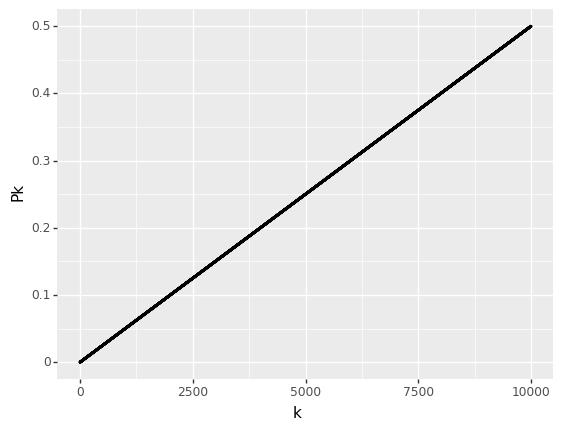

<ggplot: (8781069797060)>

In [103]:
(
    ggplot(debug_df)
    + geom_point(aes('k', 'Pk'), size = 0.1)
)